In [21]:
## Importing standards libraries

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

## Importing libraries for the Gaussian Mixture Model

from scipy.stats import multivariate_normal
from scipy.stats import norm
import seaborn as sns

## Autograd packages

## Convergence metrics

from scipy.stats import wasserstein_distance
from scipy.stats import entropy # KL-divergence
import ot #Optimal Transport


## Import functions for the experiment : 

from experiment_functions import *
from IPLA_Exp_Functions import *


dans un premier temps, à la zeub on prend une fonction de mapping connue, et on essaye de sample la posteriori sachant que la prior est une gaussian mixture classique 25 modes. 

Paramètres de la prior -> centres équirépartis entre -16 et 16. Unit variance et équipondérée

### Setting of the Experiment 

In this experiment, we will try to estimate the Maximum Marginal Likelihood with the Interacting Particle Langevin Algorithm (IPLA), as in the article : (...). But here we will try to improve / accelerate the sampling with the Dilation Path from the paper : (...). 

In this example, we take as a prior Distribution a Gaussian Mixture with 25 modes, whose parameters are defined bellow. Here is the statistical model that, we suppose, describes the relationship between x and y : (...). 

In [2]:
#We define the grid

x = np.linspace(-16, 16, 5)
y = np.linspace(-16, 16, 5)

xx, yy = np.meshgrid(x, y)


## We define the parameters of the target Gaussian Mixture

# We define the centers for each mode
centers_prior = np.c_[xx.ravel(), yy.ravel()] ## On a une matrice de 16 lignes et 2 colonnes, chaque ligne correspond à un centre

# Define the covariance matrix and the weights : 

covariances_prior = np.array([[[1, 0], [0, 1]]]*25)  # cov = 10*I_2 -> 16 times the same covariance matrix
weights_prior = np.ones(25) / 25


# We define the initial position of the particles (sample from a standard normal distribution in 2-dimensions)

sample_init = np.random.randn(1000, 2)


## Other parameters : 

nb_particles = 1000

step_size = 0.001

nb_iter = 10000

##Dimensions des variables

dx = 2

dy = 1

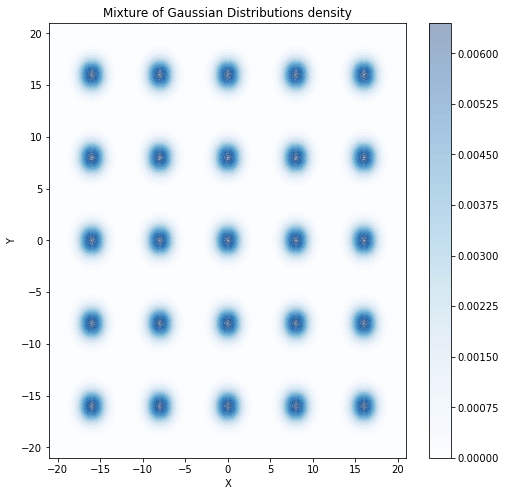

In [965]:
generate_multimodal(centers, covariances, weights)

Then, we have to define the other parameters of the experiment : $H$, $y$ and $\sigma_y$, as in the paper. We are able to plot the density of the "true" posterior distribution $p(x sachant y) $. 

Aucun sens la génération de l'opérateur H dans l'article qui pue la beuteu. Pb de dimension

In [ ]:
Id = np.eye(2)
#s_i_j = np.random.uniform(0, 1, 25)
#s_i_j.reshape((5, 5))
s_i_j = np.random.uniform(0, 1, 2)
H_tilde = np.random.randn(1, 2)
U, Sigma, Vt = np.linalg.svd(H_tilde, full_matrices=False)

Génération y comme dans l'article : 

First, we draw $x^{*}$ according to the prior distribution. And then, y = ...

On tire UN SEUL x* juste pour générer l'unique observations mais par la suite on aura plusieurs X qui seront les particules de l'algo. 

We define function that, given $\theta$ and others parameters of the model, generates the centers, covariances and weights of the posterior distribution. We use the same prior. 

We suppose dy = 1

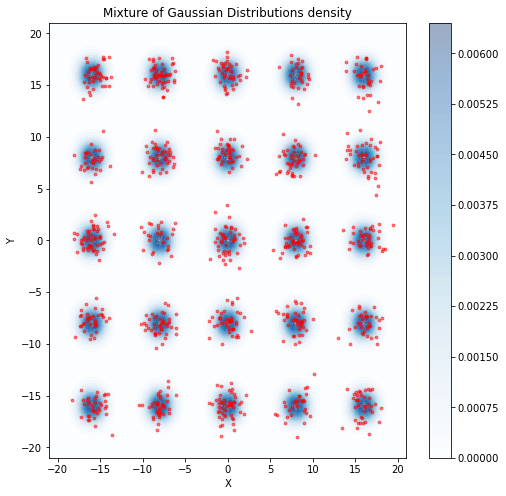

In [ ]:
x_star = sample_prior(1000, centers_prior, covariances_prior, weights_prior)

generate_multimodal(centers_prior, covariances_prior, weights_prior, x_star)

In [ ]:
y_obs = generate_obs(x_star[0], np.array([1, 2]), 0.1)

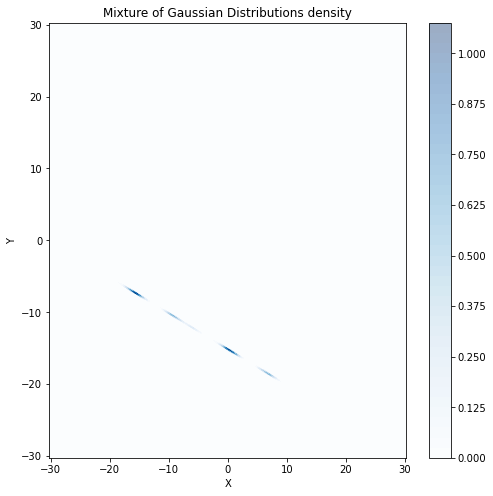

(array([[-12.45887807,  -8.91775614],
        [ -6.05568446, -12.11136892],
        [  0.34750915, -15.30498169],
        [  6.75070277, -18.49859447],
        [ 13.15389638, -21.69220724],
        [-15.65249085,  -7.30498169],
        [ -9.24929723, -10.49859447],
        [ -2.84610362, -13.69220724],
        [  3.55708999, -16.88582002],
        [  9.96028361, -20.07943279],
        [-18.84610362,  -5.69220724],
        [-12.44291001,  -8.88582002],
        [ -6.03971639, -12.07943279],
        [  0.36347722, -15.27304556],
        [  6.76667083, -18.46665834],
        [-22.03971639,  -4.07943279],
        [-15.63652278,  -7.27304556],
        [ -9.23332917, -10.46665834],
        [ -2.83013556, -13.66027111],
        [  3.57305806, -16.85388389],
        [-25.23332917,  -2.46665834],
        [-18.83013556,  -5.66027111],
        [-12.42694194,  -8.85388389],
        [ -6.02374833, -12.04749666],
        [  0.37944528, -15.24110944]]),
 array([[[ 0.8003992 , -0.3992016 ],
         [-

In [ ]:
post_params(np.array([1, 2]), 0.1, centers_prior, covariances_prior, weights_prior, y_obs, True)

Pas sûr de la façon dont on génère la posterior, mais bon on passe à la suite. 

### Interacting Particle Langevin Algorithm

Now that we have set the model of the experiment, our goal is to implement IPLA in order to find the MMLE with our observation. 

On commence l'algo a quel theta ? Et à la priori initiale ? 

We define a function that run IPLA with a dilation path on the SDE involving the particles, given a Gaussian Mixture prior. 

First, we manually set a value for $H$ and we generate one observation, drawn as it is mentionned in the Appendix of the article : 

- $ x^* \sim p_0 $, où $ p_0 $ est une mixture gaussienne équipondérée avec $ K $ composants, centrés sur des points $\mu_k$ équirépartis dans le carré $[-16, 16]$ avec une covariance unitaire.
- $ y := Hx^* + z $, où $ z \sim \mathcal{N}(0, \sigma_y^2 I_{d_y}) $.

### Densité Jointe

La densité jointe $ p_\theta(x, y) $ est donnée par :

$ p_\theta(x, y) = p(y \mid x) p_\theta(x) $

où 

- $ p(y \mid x) = \mathcal{N}(y \mid Hx, \sigma_y^2 I_{d_y})$
- $ p_\theta(x) = \frac{1}{K} \sum_{k=1}^K \mathcal{N}(x \mid \mu_k, I) $

### Log-Densité Jointe

La log-densité jointe est donc :

$ \log p_\theta(x, y) = \log \mathcal{N}(y \mid Hx, \sigma_y^2 I_{d_y}) + \log \left( \frac{1}{K} \sum_{k=1}^K \mathcal{N}(x \mid \mu_k, I) \right) $

#### 1. Log de la Densité Conditionnelle

$ \log \mathcal{N}(y \mid Hx, \sigma_y^2 I_{d_y}) = -\frac{d_y}{2} \log(2\pi \sigma_y^2) - \frac{1}{2\sigma_y^2} (y - Hx)^T (y - Hx) $

#### 2. Log de la Densité A Priori

$\log p_\theta(x) = \log \left( \frac{1}{K} \sum_{k=1}^K \mathcal{N}(x \mid \mu_k, I) \right) $

### Gradient de la Log-Densité Jointe

Pour calculer le gradient de la log-densité jointe $\log p_\theta(x, y)$ par rapport à $x$ et $H$, nous dérivons chaque terme par rapport à ces variables.

#### Gradient par rapport à \(x\)

Le gradient de $\log p_\theta(x, y)$ par rapport à $x$ est :

$ \nabla_x \log p_\theta(x, y) = \frac{1}{\sigma_y^2} H^T (y - Hx) + \sum_{k=1}^K \frac{\mathcal{N}(x \mid \mu_k, I)}{K p_\theta(x)} (- (x - \mu_k)) $

#### Gradient par rapport à \(H\)

Le gradient de $\log p_\theta(x, y)$ par rapport à $H$ est :

$ \nabla_H \log p_\theta(x, y) = \frac{1}{\sigma_y^2} (y - Hx) x^T $


In [71]:
true_theta = np.array([0.5, 0.5])

x_star = sample_prior(1, centers_prior, covariances_prior, weights_prior)

y_obs = generate_obs(x_star, true_theta, 0.1)

y_obs, x_star

(array([13.85656072]), array([[17.02965915, 10.67730312]]))

In [40]:
theta_list = np.zeros((100, 2))

for i in tqdm(range(100)): 
    
    theta_list[i] = PGD(1000, 3500, 0.00003, centers_prior, covariances_prior, weights_prior, np.array([0, 0]), 0.1, y_obs, plot = False, plot_true_theta=np.array([0, 0]))[-1]

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 3500/3500 [00:23<00:00, 145.89it/s]
/Users/tomrossa/Documents/Imperial College/Research_Project-Imperial_College/IPLA_Exp_Functions.py:111: RuntimeWarning: invalid value encountered in true_divide
  weights_posteriori = weights_posteriori / np.sum(weights_posteriori)
100%|██████████| 100/100 [39:47<00:00, 23.88s/it]


Y_OBS = -70.3

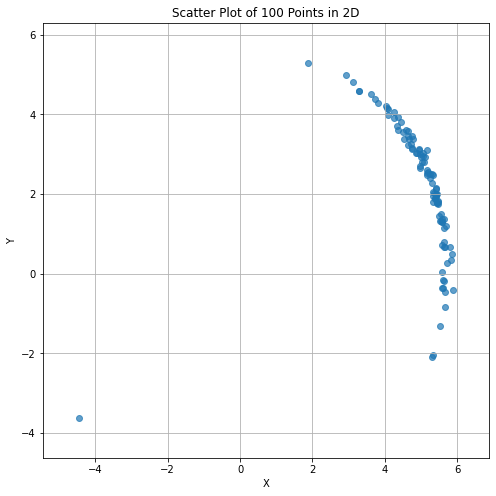

In [39]:
fig, ax = plt.subplots(figsize=(8, 8))

# Tracer les points sur le graphique
ax.scatter(theta_list[:, 0], theta_list[:, 1], alpha=0.7)

# Définir les limites de l'axe pour une meilleure visualisation
ax.set_xlim(np.min(theta_list[:, 0]) - 1, np.max(theta_list[:, 0]) + 1)
ax.set_ylim(np.min(theta_list[:, 1]) - 1, np.max(theta_list[:, 1]) + 1)

# Ajouter des labels et un titre
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Scatter Plot of 100 Points in 2D')

# Afficher la grille
ax.grid(True)

# Afficher le graphique
plt.show()

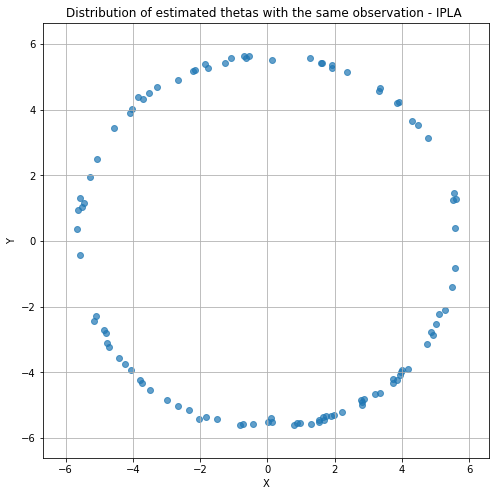

In [65]:
fig, ax = plt.subplots(figsize=(8, 8))

# Tracer les points sur le graphique
ax.scatter(theta_list[:, 0], theta_list[:, 1], alpha=0.7)

# Définir les limites de l'axe pour une meilleure visualisation
ax.set_xlim(np.min(theta_list[:, 0]) - 1, np.max(theta_list[:, 0]) + 1)
ax.set_ylim(np.min(theta_list[:, 1]) - 1, np.max(theta_list[:, 1]) + 1)

# Ajouter des labels et un titre
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Distribution of estimated thetas with the same observation - IPLA ')

# Afficher la grille
ax.grid(True)

# Afficher le graphique
plt.show()

This 2 plots have been obtained with y_observed = -13.7

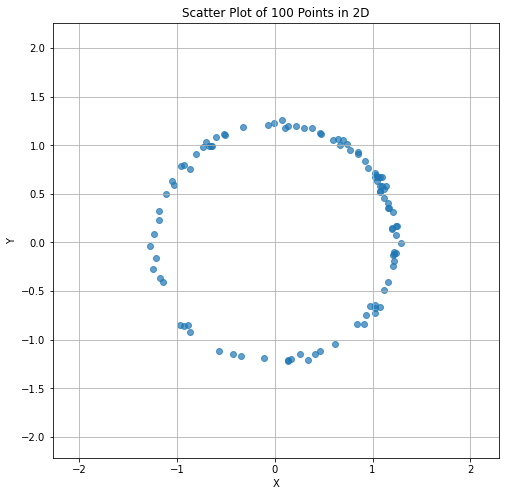

In [32]:
fig, ax = plt.subplots(figsize=(8, 8))

# Tracer les points sur le graphique
ax.scatter(theta_list[:, 0], theta_list[:, 1], alpha=0.7)

# Définir les limites de l'axe pour une meilleure visualisation
ax.set_xlim(np.min(theta_list[:, 0]) - 1, np.max(theta_list[:, 0]) + 1)
ax.set_ylim(np.min(theta_list[:, 1]) - 1, np.max(theta_list[:, 1]) + 1)

# Ajouter des labels et un titre
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Scatter Plot of 100 Points in 2D')

# Afficher la grille
ax.grid(True)

# Afficher le graphique
plt.show()

In [28]:
theta_list = np.zeros((100, 2))

for i in tqdm(range(100)): 
    
    theta_list[i] = PGD(800, 3500, 0.00003, centers_prior, covariances_prior, weights_prior, np.array([0, 0]), 0.1, y_obs, plot = False, plot_true_theta=np.array([0, 0]))[-1]

100%|██████████| 3500/3500 [00:36<00:00, 96.81it/s] 
/Users/tomrossa/Documents/Imperial College/Research_Project-Imperial_College/IPLA_Exp_Functions.py:111: RuntimeWarning: invalid value encountered in true_divide
  weights_posteriori = weights_posteriori / np.sum(weights_posteriori)
100%|██████████| 100/100 [40:50<00:00, 24.51s/it]


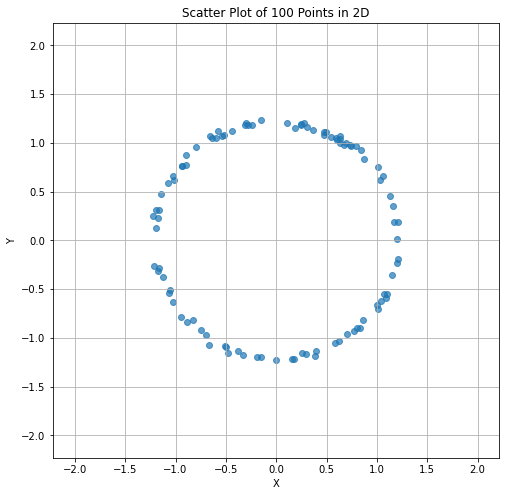

In [30]:
fig, ax = plt.subplots(figsize=(8, 8))

# Tracer les points sur le graphique
ax.scatter(theta_list[:, 0], theta_list[:, 1], alpha=0.7)

# Définir les limites de l'axe pour une meilleure visualisation
ax.set_xlim(np.min(theta_list[:, 0]) - 1, np.max(theta_list[:, 0]) + 1)
ax.set_ylim(np.min(theta_list[:, 1]) - 1, np.max(theta_list[:, 1]) + 1)

# Ajouter des labels et un titre
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Scatter Plot of 100 Points in 2D')

# Afficher la grille
ax.grid(True)

# Afficher le graphique
plt.show()

LinAlgError: singular matrix

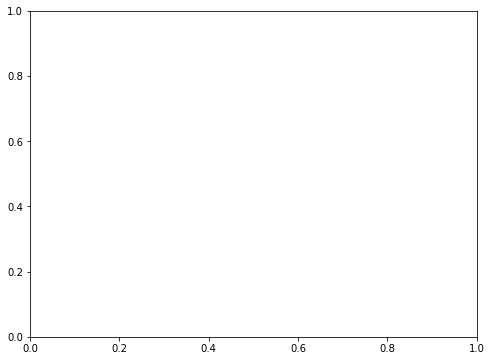

In [24]:
import pandas as pd
data = pd.DataFrame({'x': x, 'y': y})

# Tracer la carte de densité
plt.figure(figsize=(8, 6))
sns.kdeplot(data=data, x='x', y='y', fill=True, cmap='viridis', levels=30)
plt.title('Density Plot using Seaborn')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In order to confirm that we are able to correctly compute the score vecteur of the posteriori distribution given the "ground true" parameter $\theta$, we implement a gradient descent for several particles randomly drawn. We can then see that they converge to the modes of our a posteriori distribution. 

Here we plot the evolution of the position of the particles, and we can confirm that our formule for the score vector seems good as all particles converge to a mode of the distribution (which are local extrema of the log-density)

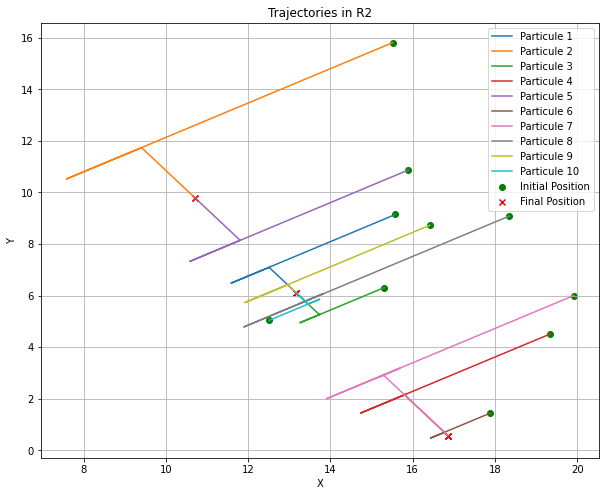

In [1053]:
# Trajectories of particles in R2
plt.figure(figsize=(10, 8))

for point_idx in range(traj.shape[1]):  # Pour chaque point (10 points au total)
    plt.plot(traj[:, point_idx, 0], traj[:, point_idx, 1], label=f'Particule {point_idx + 1}')

plt.scatter(traj[0, :, 0], traj[0, :, 1], color='green', marker='o', label='Initial Position')
plt.scatter(traj[-1, :, 0], traj[-1, :, 1], color='red', marker='x', label='Final Position')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('Trajectories in R2')
plt.legend()
plt.grid(True)
plt.show()

Now, we sample for the true posterior distribution and we do a classic gradient descent with the potentiel function (log-density), with respect to the parameter $\theta$. Then, we observe the convergence of the process to the true $\theta^{*}$ that we know. 

array([-0.00015298,  0.00042561])

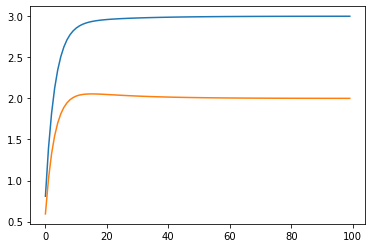

In [ ]:
sample_post = sample_prior(10000, centers_test, covariances_test, weights_test)

theta_t = np.array([0, 0])

theta_traj = np.zeros((100, 2))

step = 0.00001

for i in range(100) : 

    theta_t = theta_t - step * np.sum(grad_theta_GM(sample_post, theta_t, y_obs, 0.1) / 10000, axis = 0)

    #step *= 0.99

    theta_traj[i] = theta_t

plt.plot(np.arange(100), theta_traj)

theta_t - true_theta

The algorithm is very sensitive to the step size that need to be very small. 

array([-0.01441435, -0.00946312])

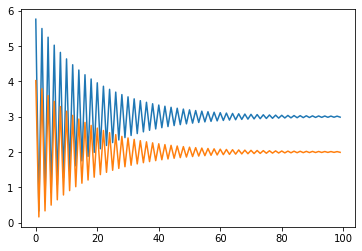

In [ ]:
sample_post = sample_prior(1000, centers_test, covariances_test, weights_test)

theta_t = np.array([0, 0])

theta_traj = np.zeros((100, 2))

step = 0.00007

for i in range(100) : 

    theta_t = theta_t - step * np.sum(grad_theta_GM(sample_post, theta_t, y_obs, 0.1) / 1000, axis = 0)

    #step *= 0.99

    theta_traj[i] = theta_t

plt.plot(np.arange(100), theta_traj)

theta_t - true_theta

In [2]:
sample_post = sample_prior(1000, centers_test, covariances_test, weights_test)

theta_t = np.array([0, 0])
step_sizes = [0.000001, 0.000005, 0.00001, 0.00003, 0.00005, 0.000072]
n_iterations = 100

plt.figure(figsize=(12, 8))

for step in step_sizes:
    theta_t = np.array([0.0, 0.0], dtype=np.float64)
    mse_traj = np.zeros(n_iterations)

    for i in range(n_iterations):
        grad = grad_theta_GM(sample_post, theta_t, y_obs, 0.1)
        theta_t -= step * np.sum(grad / 1000, axis=0)
        mse_traj[i] = np.mean((theta_t - true_theta) ** 2)

    plt.plot(np.arange(n_iterations), mse_traj, label=f'Step size = {step}')

plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.title('Evolution of MSE for Different Step Sizes')
plt.legend()
plt.grid(True)
plt.show()

print("Final theta for different step sizes:")
for step in step_sizes:
    theta_t = np.array([0.0, 0.0], dtype=np.float64)
    for i in range(n_iterations):
        grad = grad_theta_GM(sample_post, theta_t, y_obs, 0.1)
        theta_t -= step * np.sum(grad / 1000, axis=0)
    print(f'Step size = {step}, Final theta = {theta_t}')

NameError: name 'centers_test' is not defined

Therefore, we need to implement an adaptive step size for the equation updating theta. If we respect the algo, and we use the same step size to update the particles and the theta, theta may diverge if the step is too large or the particles we will converge to slowly to the posteriori distribution. 

Or maybe we can play on the coefficient of proportionnality on the step size for particles ? ? 

In [45]:
true_theta = np.array([3, 2])

#x_star = sample_prior(1, centers_prior, covariances_prior, weights_prior)

#y_obs = generate_obs(x_star, true_theta, 0.1)

centers_post, covariances_post, weights_post = post_params(true_theta, 0.1, centers_prior, covariances_prior, weights_prior, y_obs)

y_obs

array([-70.28072063])

In [69]:
def marginal_likelihood_obs(theta, x_samples, y, sigma_y):
    """
    This function computes the log-likelihood of a parameter theta in the context of our experiment, given the observed data point "y"
    """

    likelihoods = []

    for x in x_samples:

        mean = np.dot(theta, x)

        ##LOG-LIKELIHOOD
        likelihood = multivariate_normal.pdf(y, mean=mean, cov=sigma_y**2)
        likelihoods.append(likelihood)
        
    return np.mean(likelihoods)

In [67]:

def PGD(nb_particles, nb_iter, step_size, centers_prior, covariances_prior, weights_prior, theta_0, sigma_y, y_obs,
        coef_particle = 1, plot = False, plot_true_theta = None) : 
    """
    This function executes the Particle Gradient Descent in the context of our experiment. Given :
    - The number of particles
    - The number of iterations
    - The step size
    - Parameters of the prior distribution
    - The observed data point "y"
    - The initializing theta_0
    """

    theta_t = theta_0

    dx = theta_0.shape[0]

    sample = sample_prior(nb_particles, centers_prior, covariances_prior, weights_prior)

    time_SDE = 0

    theta_traj = np.zeros((nb_iter, dx))

    for i in tqdm(range(nb_iter)) : 

        #We don't need to compute the parameters of the posteriori distribution given the updated theta because we use another formula
        #centers_post, covariances_post, weights_post = post_params(theta_t, sigma_y, centers_prior, covariances_prior, weights_prior)

        time_SDE += step_size

        ## on prend le gradient selon x de la posterior actualisée avec theta_t et qui est aussi une mixture Gaussienne
        grad = ((1/sigma_y**2) * theta_t[:, np.newaxis] * (y_obs - np.dot(theta_t, sample.T))).T 

        grad += grad_multimodal_opti(sample, weights_prior, centers_prior, covariances_prior) 

        grad_update = step_size * grad * coef_particle
        
        #Noise
        noise =  np.sqrt(2 * step_size) * np.random.randn(nb_particles, dx)

        sample += grad_update + noise #Warning sign

        #MAJ THETA we need a fct that compute gradient of the potential wrt to theta

        grad_theta = grad_theta_GM(sample, theta_t, y_obs, sigma_y) #renvoie un vecteur avec tous les gradients

        grad_theta_update = np.sum(grad_theta, axis = 0) ## ON MULTIPLIE CHAQUE PARTICLE A SON PAS SPECIFIQUE

        theta_t = theta_t - (step_size / nb_particles) * grad_theta_update 

        theta_traj[i] = theta_t

        if i % 500 == 0: 

            theta_1 = np.linspace(-5, 5, 25)
            theta_2 = np.linspace(-5, 5, 25)
            theta_1_grid, theta_2_grid = np.meshgrid(theta_1, theta_2)

            x_samples = sample

            # Calculer la vraisemblance pour chaque paire de theta
            likelihood_values = np.zeros_like(theta_1_grid)
            for i in tqdm(range(theta_1_grid.shape[0])):
                for j in range(theta_1_grid.shape[1]):
                    theta = np.array([theta_1_grid[i, j], theta_2_grid[i, j]])
                    likelihood_values[i, j] = marginal_likelihood_obs(theta, x_samples, y_obs, 0.1)

            # Plot
            plt.figure(figsize=(10, 8))
            contour = plt.contourf(theta_1_grid, theta_2_grid, likelihood_values, levels=50, cmap='viridis')
            plt.colorbar(contour)
            plt.scatter(true_theta[0], true_theta[1], color='red', marker='x', s=100, label='True Theta')
            plt.xlabel('Theta 1')
            plt.ylabel('Theta 2')
            plt.title('Likelihood of observation y given theta')
            plt.legend()
            plt.show()


    centers_post, covariances_post, weights_post = post_params(plot_true_theta, sigma_y, centers_prior, covariances_prior, weights_prior, y_obs)

    if plot :

        generate_multimodal(centers_post, covariances_post, weights_post, sample)

        plt.plot(np.arange(nb_iter), theta_traj)
        plt.show()

    return theta_traj

  0%|          | 0/1500 [00:00<?, ?it/s]

100%|██████████| 25/25 [01:26<00:00,  3.46s/it]


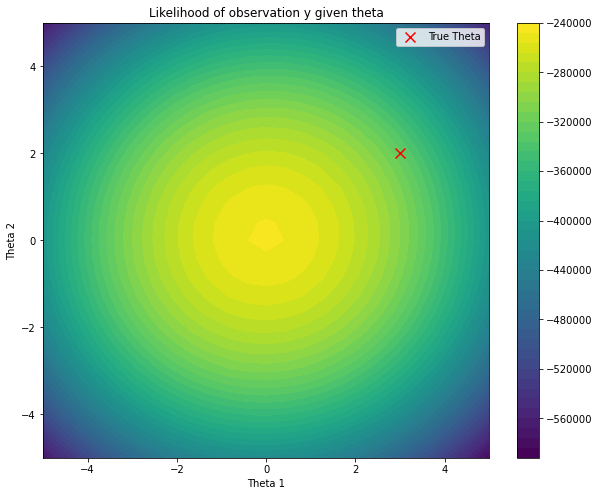

100%|██████████| 25/25 [01:20<00:00,  3.22s/it]t/s]


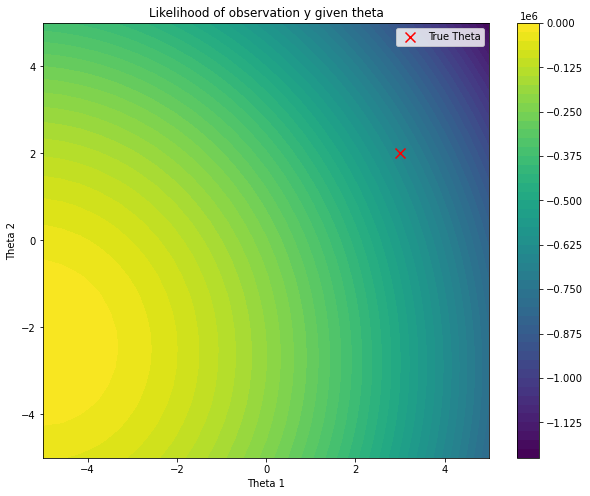

100%|██████████| 25/25 [01:11<00:00,  2.87s/it]t/s]


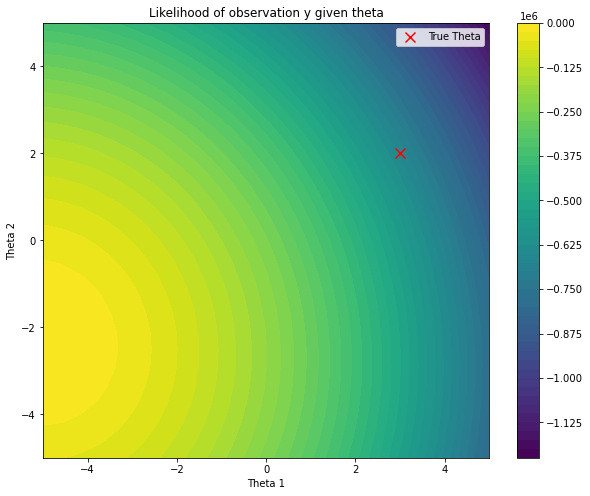

100%|██████████| 1500/1500 [04:11<00:00,  5.97it/s] 


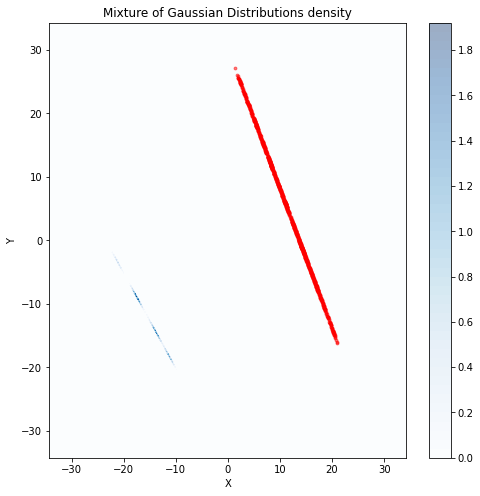

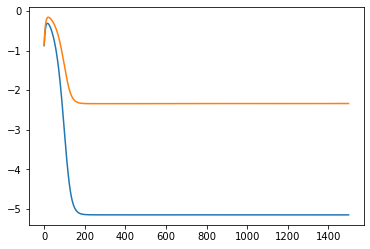

array([[-0.87569281, -0.85601346],
       [-0.77150456, -0.73536398],
       [-0.68423915, -0.63421552],
       ...,
       [-5.1455227 , -2.33671336],
       [-5.14548985, -2.3366998 ],
       [-5.14545802, -2.33670637]])

In [68]:
PGD(1000, 1500, 0.00001, centers_prior, covariances_prior, weights_prior, np.array([-1, -1]), 0.1, y_obs, plot = True, plot_true_theta=true_theta)

100%|██████████| 20/20 [00:55<00:00,  2.78s/it]


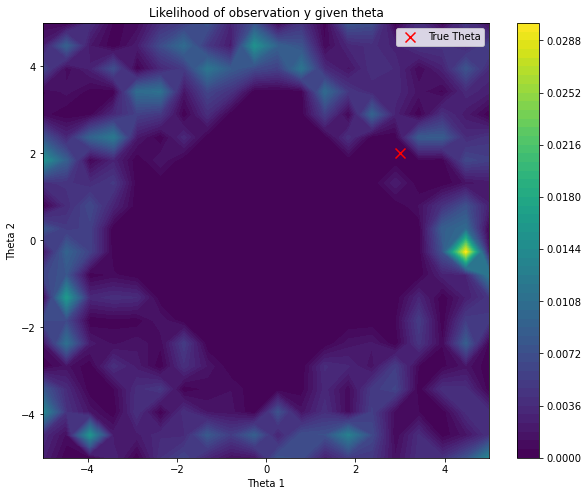

In [70]:
theta_1 = np.linspace(-5, 5, 20)
theta_2 = np.linspace(-5, 5, 20)
theta_1_grid, theta_2_grid = np.meshgrid(theta_1, theta_2)

x_samples = sample_prior(1000, centers_prior, covariances_prior, weights_prior)
#x_samples =  sample_prior(1000, centers_post, covariances_post, weights_post)

# Calculer la vraisemblance pour chaque paire de theta
likelihood_values = np.zeros_like(theta_1_grid)
for i in tqdm(range(theta_1_grid.shape[0])):
    for j in range(theta_1_grid.shape[1]):
        theta = np.array([theta_1_grid[i, j], theta_2_grid[i, j]])
        likelihood_values[i, j] = marginal_likelihood_obs(theta, x_samples, y_obs, 0.1)

# Plot
plt.figure(figsize=(10, 8))
contour = plt.contourf(theta_1_grid, theta_2_grid, likelihood_values, levels=50, cmap='viridis')
plt.colorbar(contour)
plt.scatter(true_theta[0], true_theta[1], color='red', marker='x', s=100, label='True Theta')
plt.xlabel('Theta 1')
plt.ylabel('Theta 2')
plt.title('Likelihood of observation y given theta')
plt.legend()
plt.show()


We have noticed that the performance and the convergence of the algorithm depends on $\theta_0$. The more the parameter is far from $\theta^{*}$, the more difficulties it has to converge. Very often, the algorithm converges and has a stationnary behaviour for a wrong theta. 

Here, we try the IPLA, which is very similar to PGD

100%|██████████| 10000/10000 [01:34<00:00, 106.23it/s]


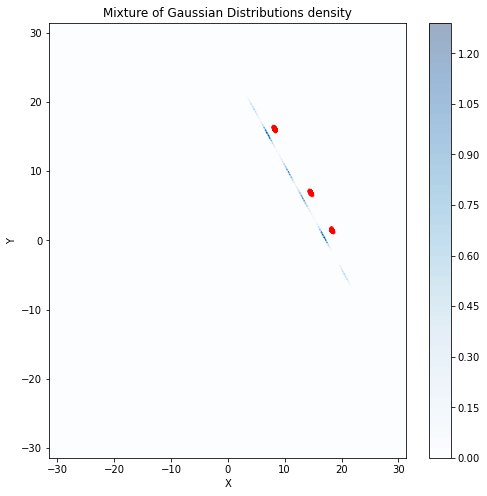

array([2.68063269, 1.84832552])

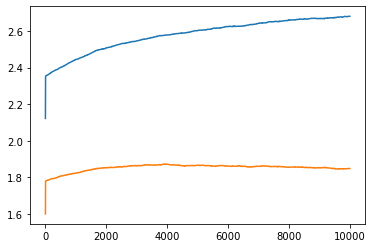

In [1089]:
IPLA(1000, 10000, 0.00001, centers_prior, covariances_prior, weights_prior, np.array([2, 1.5]), 0.1, y_obs, coef_particle = 1)

100%|██████████| 15000/15000 [01:47<00:00, 139.29it/s]


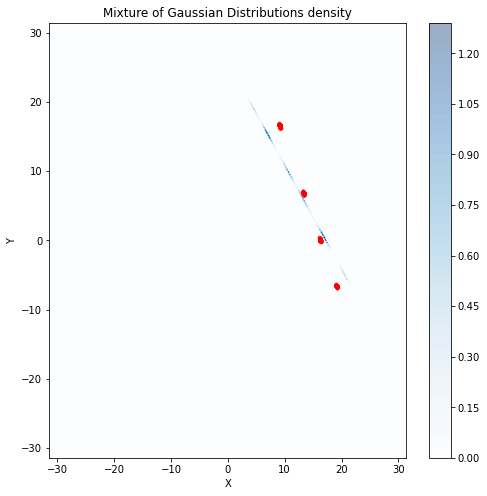

array([3.17811954, 1.37185696])

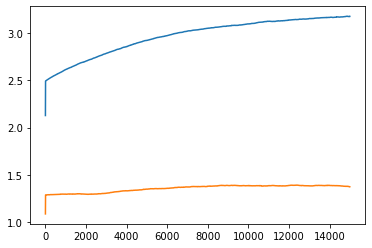

In [1099]:
IPLA(1000, 15000, 0.00001, centers_prior, covariances_prior, weights_prior, np.array([2, 1]), 0.1, y_obs, coef_particle = 1)

Here, IPLA with the dilation path : 

100%|██████████| 1500/1500 [00:20<00:00, 74.54it/s] 


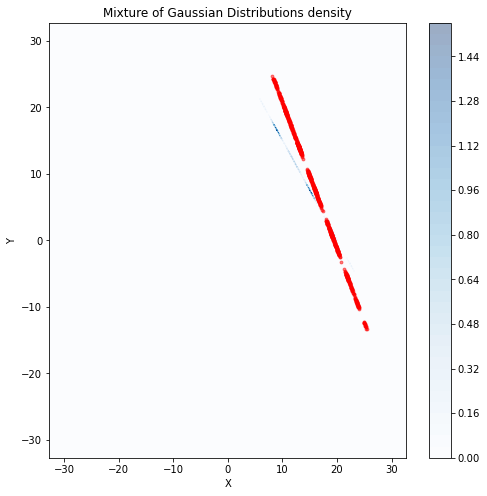

array([3.10654931, 1.40817215])

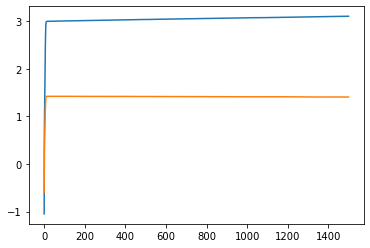

In [1041]:
IPLA_dilation(1000, 0.00001, 1500, centers_prior, covariances_prior, weights_prior, np.array([2, 1]), 0.1, y_obs, 1.9, 10, bound = 100, alpha = 0.01)

  0%|          | 0/1500 [00:00<?, ?it/s]

100%|██████████| 1500/1500 [00:10<00:00, 144.24it/s]


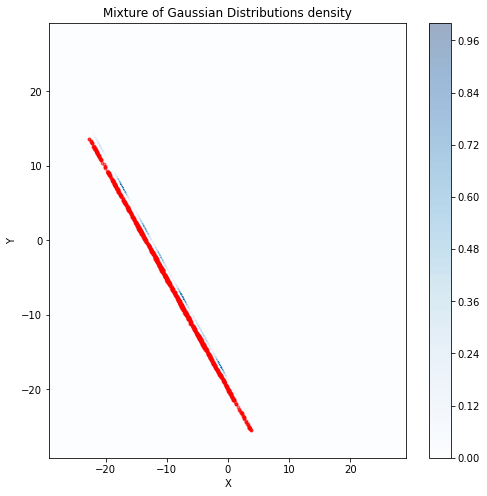

array([[1.24701609, 0.64875673],
       [0.8003129 , 0.43248963],
       [0.53080013, 0.29736463],
       ...,
       [1.52039637, 1.02310633],
       [1.52037239, 1.02326079],
       [1.52046309, 1.02313657]])

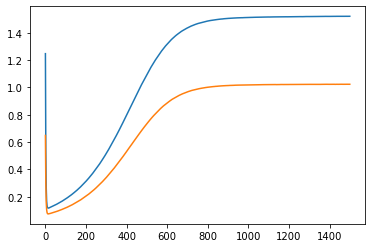

In [1232]:
IPLA_dilation_taming(1000, 0.000005, 1500, centers_prior, covariances_prior, weights_prior, np.array([2, 1]), 0.1, y_obs, 0.3, 10, True, true_theta)

In [17]:
true_theta = np.array([3, 2])

x_star = sample_prior(1, centers_prior, covariances_prior, weights_prior)

y_obs = generate_obs(x_star, true_theta, 0.1)

centers_post, covariances_post, weights_post = post_params(true_theta, 0.1, centers_prior, covariances_prior, weights_prior, y_obs)

y_obs

array([20.32966754])

Comparison of each method : 

100%|██████████| 2500/2500 [00:33<00:00, 74.27it/s] 


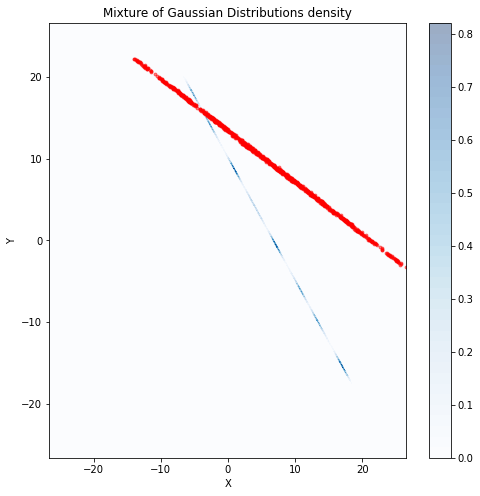

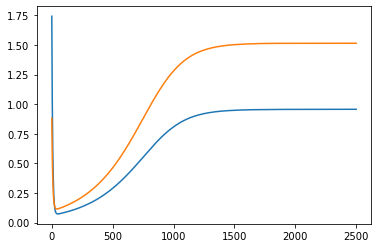

array([[1.74211579, 0.88121865],
       [1.52020382, 0.77893943],
       [1.328695  , 0.69061052],
       ...,
       [0.95649537, 1.5140941 ],
       [0.95648836, 1.51409516],
       [0.95648378, 1.51409385]])

In [20]:
PGD(1000, 2500, 0.00001, centers_prior, covariances_prior, weights_prior, np.array([2, 1]), 0.10, y_obs, plot = True, plot_true_theta=true_theta)

  1%|▏         | 37/2500 [00:00<00:28, 85.96it/s]

100%|██████████| 2500/2500 [00:30<00:00, 82.93it/s] 


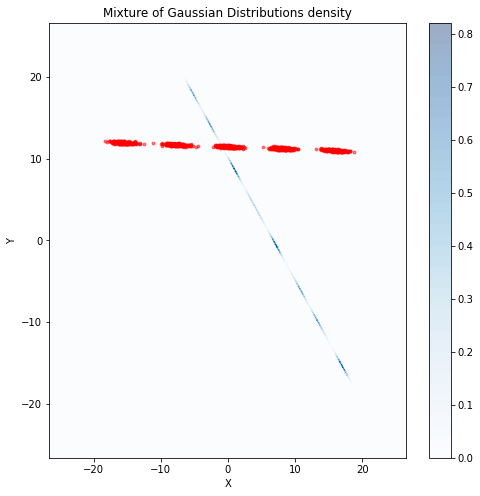

array([[1.74228781, 0.89274698],
       [1.51925826, 0.79924091],
       [1.32543055, 0.71760164],
       ...,
       [0.05403893, 1.77238123],
       [0.05411136, 1.77236114],
       [0.05427414, 1.77223389]])

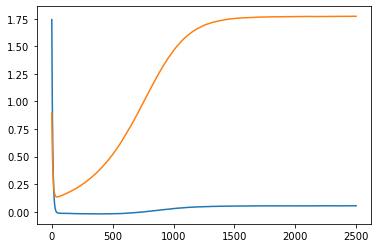

In [21]:
IPLA(1000, 2500, 0.00001, centers_prior, covariances_prior, weights_prior, np.array([2, 1]), 0.10, y_obs, plot = True, plot_true_theta=true_theta)

100%|██████████| 2500/2500 [00:33<00:00, 75.00it/s] 


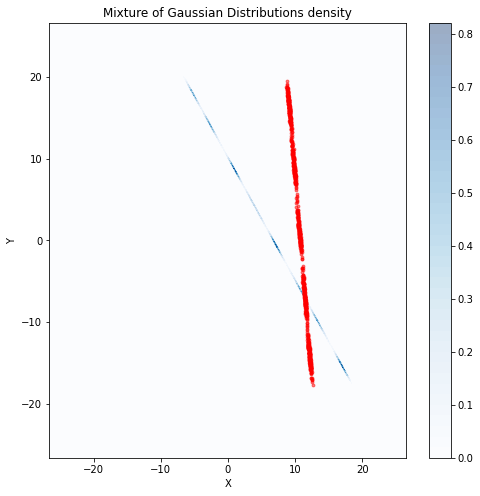

array([[0.56362559, 0.18754568],
       [0.19576069, 0.04364127],
       [0.09316805, 0.01378891],
       ...,
       [1.04092027, 0.10421482],
       [1.0409455 , 0.10424096],
       [1.04116764, 0.10397247]])

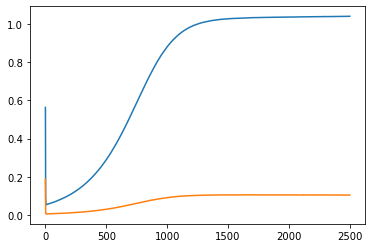

In [22]:
IPLA_dilation_taming(1000, 0.00001, 2500, centers_prior, covariances_prior, weights_prior, np.array([2, 1]), 0.1, y_obs, 0.3, 10, plot = True, plot_true_theta=true_theta)